<a href="https://colab.research.google.com/github/Fin-N1049/DeepLearning/blob/main/RBM%26DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# --- RBM and DBN (Simple Implementation) ---
# Finson N | Minimal PyTorch Version | Runs on CPU or GPU
# --------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ============== RBM Implementation ==============
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.v_bias = nn.Parameter(torch.zeros(n_vis))

    def sample_h(self, v):
        prob_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v):
        prob_h, h = self.sample_h(v)
        prob_v, v_recon = self.sample_v(h)
        return v, v_recon

    def contrastive_divergence(self, v, lr=0.01):
        prob_h0, h0 = self.sample_h(v)
        prob_v1, v1 = self.sample_v(h0)
        prob_h1, h1 = self.sample_h(v1)

        # Update weights
        self.W.data += lr * (torch.matmul(prob_h0.t(), v) - torch.matmul(prob_h1.t(), v1)) / v.size(0)
        self.v_bias.data += lr * torch.mean(v - v1, dim=0)
        self.h_bias.data += lr * torch.mean(prob_h0 - prob_h1, dim=0)

        loss = torch.mean((v - v1) ** 2)
        return loss

# ============== DBN Implementation ==============
class DBN(nn.Module):
    def __init__(self, layer_sizes):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList([
            RBM(layer_sizes[i], layer_sizes[i + 1])
            for i in range(len(layer_sizes) - 1)
        ])

    def pretrain(self, data, epochs=1, lr=0.01):
        input_data = data
        for i, rbm in enumerate(self.rbm_layers):
            print(f"Training RBM layer {i + 1}/{len(self.rbm_layers)}...")
            for epoch in range(epochs):
                epoch_loss = 0
                for batch, _ in tqdm(input_data):
                    v = batch.view(batch.size(0), -1)
                    loss = rbm.contrastive_divergence(v, lr)
                    epoch_loss += loss.item()
                print(f"  Epoch {epoch+1}: Loss = {epoch_loss / len(input_data):.4f}")

            # Pass activations to next layer
            new_data = []
            for batch, _ in input_data:
                v = batch.view(batch.size(0), -1)
                prob_h, _ = rbm.sample_h(v)
                new_data.append((prob_h.detach(), _))
            input_data = [(x, y) for x, y in new_data]

# ============== Run on MNIST ==============
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define DBN (784 -> 512 -> 256)
dbn = DBN([784, 512, 256])

# Pretrain
dbn.pretrain(train_loader, epochs=1, lr=0.01)

print("✅ DBN pretraining complete!")


100%|██████████| 9.91M/9.91M [00:00<00:00, 49.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


Training RBM layer 1/2...


100%|██████████| 938/938 [00:12<00:00, 73.61it/s]


  Epoch 1: Loss = 0.1297
Training RBM layer 2/2...


100%|██████████| 938/938 [00:02<00:00, 337.94it/s]


  Epoch 1: Loss = 0.2281
✅ DBN pretraining complete!


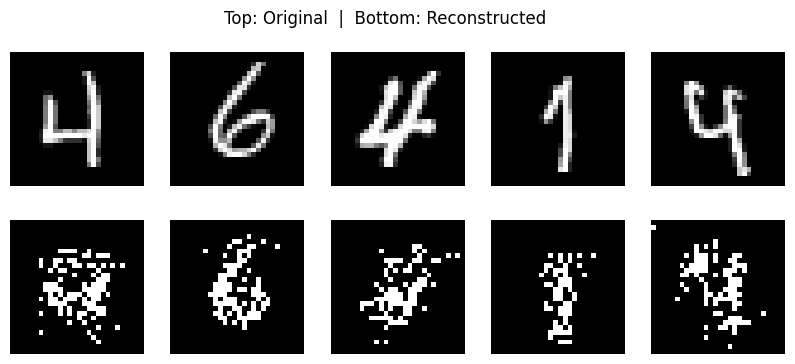

In [9]:
import matplotlib.pyplot as plt

# Get one batch from MNIST
batch, _ = next(iter(train_loader))
v = batch.view(batch.size(0), -1)

# Pass through the first RBM
rbm = dbn.rbm_layers[0]
v, v_recon = rbm.forward(v)

# Show original vs reconstructed
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(v[i].view(28, 28).detach(), cmap="gray")
    plt.axis("off")
    # Reconstructed
    plt.subplot(2, n, i + n + 1)
    plt.imshow(v_recon[i].view(28, 28).detach(), cmap="gray")
    plt.axis("off")
plt.suptitle("Top: Original  |  Bottom: Reconstructed", fontsize=12)
plt.show()
